In [2]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pygrib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import time

def print_time(t0):
    t1 = time.time()
    return t1-t0

In [3]:
# starting and ending viewazimuths
azim_start = 270
azim_end = 230

# starting and ending view elevations
elev_start = 90
elev_end = 25

# starting and ending zooms
dist_start = 230
dist_end = 130

#airport coordinates
lat_DEN = 39.7392
lon_DEN = -104.9903
lat_MIA = 25.7617
lon_MIA = -80.1918

# starting and ending center latitude
lat_start = 38.5
lat_end = (lat_DEN+lat_MIA)/2

# starting and ending longitude
lon_start = -97.5
lon_end = (lon_DEN+lon_MIA)/2

# starting and ending layer separation
delev_start = 0
delev_end = 0

#latitude windows
degree_window_start = 5
degree_window_end = 5

# delta center degrees
# latitude window for center
# tradoff with dist
ddeg = 1

# flight path height
flight_maxz = 5

# initialize flight list
flight_lat = []
flight_lon = []
flight_z = []

#save files setup
savepath = '../plots/map/movie/animate_test/'
filename = 'stage8_'


num_steps = 10

t0 = time.time()

variables = ['Total Cloud Cover']
colors = ['viridis']
ranges = [(0,100)]

for i in range(num_steps):
    
    flight_lat.append(lat_DEN-i*((lat_DEN-lat_MIA)/(num_steps-1)))
    flight_lon.append(lon_DEN-i*((lon_DEN-lon_MIA)/(num_steps-1)))
    flight_z.append(((-(1/flight_maxz)*((num_steps-1)/2)**2)**-1)*(i-(num_steps-1)/2)**2+(flight_maxz))
    
    delev = delev_start-i*((delev_start-delev_end)/(num_steps-1))
    degree_window = degree_window_start-i*((degree_window_start-degree_window_end)/(num_steps-1))
    hour = str(i-24*(i//24)).zfill(2)
    day = str(1+i//24).zfill(2)
    try:
        grbs = pygrib.open(f'../data/weather/august_full/rap_130_201808{day}_{hour}00_000.grb2')
    except:
        pass
    
    datas = []
    elev = np.arange(len(variables))*delev

    for variable in variables:
        grb = grbs.select(name=variable)[0]
        lats, lons = grb.latlons()
        datas.append(grb['values'])

    map = Basemap(llcrnrlon=-360,llcrnrlat=-90,urcrnrlon=360,urcrnrlat=90,)

    fig = plt.figure(figsize=[10,10],dpi=150)
    ax = Axes3D(fig)

    ax.add_collection3d(map.drawcoastlines(linewidth=0.25))
    ax.add_collection3d(map.drawcountries(linewidth=0.35))

    ax.set_axis_off()
    ax.azim = azim_start-i*((azim_start-azim_end)/(num_steps-1))
    ax.elev = elev_start-i*((elev_start-elev_end)/(num_steps-1))
    ax.dist = dist_start-i*((dist_start-dist_end)/(num_steps-1))
    
    center_lat = lat_start-i*((lat_start-lat_end)/(num_steps-1))
    center_lon = lon_start-i*((lon_start-lon_end)/(num_steps-1))


    for ix,data in enumerate(datas):
        # fourth dimention - colormap
        # create colormap according to x-value (can use any 50x50 array)
        color_dimension = data # change to desired fourth dimension
        minn, maxx = color_dimension.min(), color_dimension.max()
        norm = matplotlib.colors.Normalize(minn, maxx)
        m = plt.cm.ScalarMappable(norm=norm, cmap=colors[ix])
        m.set_array([])
        fcolors = m.to_rgba(color_dimension)
        Z_DEN = np.ones(lats.shape)*elev[ix]+delev/10
        Z_MIA = np.ones(lats.shape)*elev[ix]+delev/10
        mask_DEN = np.ma.masked_where((np.sqrt((lats-lat_DEN)**2 + (lons-lon_DEN)**2) > degree_window), Z_DEN)
        mask_MIA = np.ma.masked_where((np.sqrt((lats-lat_MIA)**2 + (lons-lon_MIA)**2) > degree_window), Z_MIA)
        Z_DEN[np.where(np.ma.getmask(mask_DEN)==True)] = np.nan # or np.where(np.ma.getmask(mask2)==True)] = np.nan
        Z_MIA[np.where(np.ma.getmask(mask_MIA)==True)] = np.nan
        
        ax.plot_surface(lons,lats,-1*Z_DEN,cstride=10,rstride=10,facecolors=fcolors, vmin=ranges[ix][0], vmax=ranges[ix][0], shade=False, zorder=1)
        ax.plot_surface(lons,lats,-1*Z_MIA,cstride=10,rstride=10,facecolors=fcolors, vmin=ranges[ix][0], vmax=ranges[ix][0], shade=False, zorder=1)
        ax.scatter(flight_lon, flight_lat, flight_z, color='r',marker='.',linewidth=3, zorder=2)
        ax.scatter(flight_lon[-1], flight_lat[-1], flight_z[-1],color='r',marker='o',linewidth=10, zorder=3)

    ax.set_xlim3d(center_lon-ddeg,center_lon+ddeg)
    ax.set_ylim3d(center_lat-ddeg,center_lat+ddeg)
    if i < 10:
        fig.savefig(f'{savepath}{filename}0000{i}.png', dpi=fig.dpi)
    elif i >=10 and i < 100:
        fig.savefig(f'{savepath}{filename}000{i}.png', dpi=fig.dpi)
    elif i >=100 and i < 1000:
        fig.savefig(f'{savepath}{filename}00{i}.png', dpi=fig.dpi)
    elif i > 1000:
        fig.savefig(f'{savepath}{filename}0{i}.png', dpi=fig.dpi)
    plt.close()
    print(f'Printed {filename}0000{i}.png in',print_time(t0),'seconds')
    t0 = time.time()

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Printed stage8_00000.png in 3.133776903152466 seconds
Printed stage8_00001.png in 3.22939395904541 seconds
Printed stage8_00002.png in 3.040271043777466 seconds
Printed stage8_00003.png in 3.1109418869018555 seconds
Printed stage8_00004.png in 3.16105580329895 seconds
Printed stage8_00005.png in 3.0690670013427734 seconds
Printed stage8_00006.png in 3.1209521293640137 seconds
Printed stage8_00007.png in 3.0003159046173096 seconds
Printed stage8_00008.png in 2.995243787765503 seconds
Printed stage8_00009.png in 3.1552541255950928 seconds


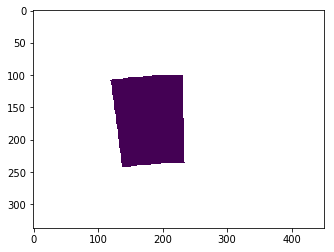

In [19]:
plt.imshow(mask)

In [19]:
mask = np.ma.masked_where((np.absolute(lats-lat_MIA)<lat_window,Z))

TypeError: masked_where() missing 1 required positional argument: 'a'

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


nan